In [55]:
import pandas as pd
import numpy as np
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Read in data of different assets

In [56]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [57]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')
# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [58]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)

## Calculate different features

## BTC

### ADX calculation
Below 20: Indicates a weak trend or a ranging market. The asset is likely moving sideways, and trading strategies that depend on trend-following may be less effective. <br>
20 to 25: Indicates a potential emerging trend. Traders may begin to look for signals to enter positions. <br>
25 to 40: Indicates a strengthening trend. This is often where trend-following strategies can be more effective. Depending on the asset, this could be considered a moderately strong trend. <br>
40 to 60: Indicates a strong trend. Here, the asset is trending strongly in one direction, making it more suitable for trend-following strategies. <br>
Above 60: Indicates an extremely strong trend, which might also signal an overbought or oversold condition, suggesting potential reversals. <br>

In [59]:
# Calculate lagged prices
btc['PrevHigh'] = btc['High'].shift(1)
btc['PrevLow'] = btc['Low'].shift(1)
btc['PrevClose'] = btc['Close'].shift(1)

# Calculate true range component
btc['TR1'] = btc['High'] - btc['Low']
btc['TR2'] = abs(btc['High'] - btc['PrevClose'])
btc['TR3'] = abs(btc['Low'] - btc['PrevClose'])

# Calculate true range as the max of the three TRs
btc['TR'] = btc[['TR1', 'TR2', 'TR3']].max(axis=1)
btc.at[btc.index[0], 'TR'] = np.nan

In [60]:
# Initialize +DM and -DM columns
btc['+DM'] = 0.0
btc['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(btc)):
    high_diff = btc['High'].iloc[i] - btc['PrevHigh'].iloc[i]
    low_diff = btc['PrevLow'].iloc[i] - btc['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        btc.at[btc.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        btc.at[btc.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
btc['TR_smooth'] = btc['TR'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

btc['+DM_smooth'] = btc['+DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '+DM_smooth'] = np.nan
btc['-DM_smooth'] = btc['-DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
btc['+DI'] = (btc['+DM_smooth'] / btc['TR_smooth']) * 100
btc['-DI'] = (btc['-DM_smooth'] / btc['TR_smooth']) * 100

# Calculate DX and ADX
btc['DX'] = (abs(btc['+DI'] - btc['-DI']) / (btc['+DI'] + btc['-DI'])) * 100
btc['ADX'] = btc['DX'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [61]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Separate gains and losses
btc['Gain'] = btc['PriceChange'].where(btc['PriceChange'] > 0, 0)
btc['Loss'] = -btc['PriceChange'].where(btc['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

btc.loc[btc.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator
Varies from value of 0 to 100, the bounds of 80 and 20 are frequently taken as overbought and oversold levels

In [62]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

### MACD

In [63]:
btc['EMA_6'] = btc['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

### Breaking of 2 consecutive high

In [64]:
btc['PrevHigh2'] = btc['High'].shift(2)
btc['BreakHigh2'] = (btc['High'] > btc['PrevHigh']) & (btc['PrevHigh'] > btc['PrevHigh2'])

In [65]:
btc['TROpen'] = btc['Open'].diff()
btc['TRHigh'] = btc['High'].diff()
btc['TRLow'] = btc['Low'].diff()
btc['TRClose'] = btc['Close'].diff()
btc['TRShort_SMA'] = btc['SMAVG (5)  on Close'].diff()
btc['TRLong_SMA'] = btc['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
btc['Short_EMA'] = btc['Close'].ewm(span=5, adjust=False).mean()
btc['Long_EMA'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['TRShort_EMA'] = btc['Short_EMA'].diff()
btc['TRLong_EMA'] = btc['Long_EMA'].diff()

btc['DayOfWeek'] = btc['Date'].dt.dayofweek

#calculate returns
btc["returns"] = (btc["Close"] - btc["Open"])/btc["Open"]
btc["log_returns"] = np.log(btc['Close'] / btc['Open'])

### Breaking of 2 consecutive high

In [66]:
btc['PrevHigh2'] = btc['High'].shift(2)
btc['BreakHigh2'] = (btc['High'] > btc['PrevHigh']) & (btc['PrevHigh'] > btc['PrevHigh2'])

In [67]:
btc['TROpen'] = btc['Open'].diff()
btc['TRHigh'] = btc['High'].diff()
btc['TRLow'] = btc['Low'].diff()
btc['TRClose'] = btc['Close'].diff()
btc['TRShort_SMA'] = btc['SMAVG (5)  on Close'].diff()
btc['TRLong_SMA'] = btc['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
btc['Short_EMA'] = btc['Close'].ewm(span=5, adjust=False).mean()
btc['Long_EMA'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['TRShort_EMA'] = btc['Short_EMA'].diff()
btc['TRLong_EMA'] = btc['Long_EMA'].diff()

btc['DayOfWeek'] = btc['Date'].dt.dayofweek

#calculate returns
btc["simple_returns"] = btc['Close'].pct_change()
btc["log_returns"] = np.log(btc['Close'] / btc['Close'].shift(1))

In [68]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
btc['STD15'] = btc['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
btc['BB_Upper'] = btc['SMAVG (15)  on Close'] + (btc['STD15'] * 2)
btc['BB_Lower'] = btc['SMAVG (15)  on Close'] - (btc['STD15'] * 2)

In [69]:
#drop non-required columns except for technical indicators, date, and close prices
btc = btc.drop(columns=['High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

### ADF Fuller Test (test for stationarity for all columns)

In [70]:
def adf_test_all_columns(df, name='Dataset'):
    print(f"\n ADF Test Results for {name}")
    for col in df.columns:
        if col != 'Date':
            series = df[col].dropna()
            result = adfuller(series)
            print(f"\n Column: {col}")
            print(f"ADF Statistic: {result[0]:.4f}")
            print(f"p-value: {result[1]:.4f}")
            print("Conclusion: Stationary" if result[1] < 0.05 else "Conclusion: Non-Stationary")


In [71]:
# Run ADF test on BTC and SPY
adf_test_all_columns(btc, name='BTC')


 ADF Test Results for BTC

 Column: Open
ADF Statistic: -1.5852
p-value: 0.4910
Conclusion: Non-Stationary

 Column: Close
ADF Statistic: -1.5779
p-value: 0.4947
Conclusion: Non-Stationary

 Column: ADX
ADF Statistic: -35.9062
p-value: 0.0000
Conclusion: Stationary

 Column: RSI
ADF Statistic: -23.0674
p-value: 0.0000
Conclusion: Stationary

 Column: %K
ADF Statistic: -28.5613
p-value: 0.0000
Conclusion: Stationary

 Column: %D
ADF Statistic: -21.6956
p-value: 0.0000
Conclusion: Stationary

 Column: MACD
ADF Statistic: -20.5426
p-value: 0.0000
Conclusion: Stationary

 Column: BreakHigh2
ADF Statistic: -72.0837
p-value: 0.0000
Conclusion: Stationary

 Column: TROpen
ADF Statistic: -23.7660
p-value: 0.0000
Conclusion: Stationary

 Column: TRHigh
ADF Statistic: -46.9865
p-value: 0.0000
Conclusion: Stationary

 Column: TRLow
ADF Statistic: -24.0386
p-value: 0.0000
Conclusion: Stationary

 Column: TRClose
ADF Statistic: -23.7773
p-value: 0.0000
Conclusion: Stationary

 Column: TRShort_SMA


In [72]:
#Open and Close prices are NOT stationary
#first difference Open and Close prices
btc["first_difference_open"] = btc["Open"].diff()
btc["first_difference_close"] = btc["Close"].diff()

## SPY

### ADX

In [73]:
# Calculate lagged prices
spy['PrevHigh'] = spy['High'].shift(1)
spy['PrevLow'] = spy['Low'].shift(1)
spy['PrevClose'] = spy['Close'].shift(1)

# Calculate true range component
spy['TR1'] = spy['High'] - spy['Low']
spy['TR2'] = abs(spy['High'] - spy['PrevClose'])
spy['TR3'] = abs(spy['Low'] - spy['PrevClose'])

# Calculate true range as the max of the three TRs
spy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)
spy.at[spy.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
spy['+DM'] = 0.0
spy['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(spy)):
    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]
    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        spy.at[spy.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        spy.at[spy.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
spy['TR_smooth'] = spy['TR'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

spy['+DM_smooth'] = spy['+DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '+DM_smooth'] = np.nan
spy['-DM_smooth'] = spy['-DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
spy['+DI'] = (spy['+DM_smooth'] / spy['TR_smooth']) * 100
spy['-DI'] = (spy['-DM_smooth'] / spy['TR_smooth']) * 100

# Calculate DX and ADX
spy['DX'] = (abs(spy['+DI'] - spy['-DI']) / (spy['+DI'] + spy['-DI'])) * 100
spy['ADX'] = spy['DX'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [74]:
# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Separate gains and losses
spy['Gain'] = spy['PriceChange'].where(spy['PriceChange'] > 0, 0)
spy['Loss'] = -spy['PriceChange'].where(spy['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

spy.loc[spy.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator

In [75]:
k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()

### MACD

In [76]:
spy['EMA_6'] = spy['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

### Breaking of 2 consecutive highs

In [ ]:
spy['PrevHigh2'] = spy['High'].shift(2)
spy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])

In [78]:
spy['TROpen'] = spy['Open'].diff()
spy['TRHigh'] = spy['High'].diff()
spy['TRLow'] = spy['Low'].diff()
spy['TRClose'] = spy['Close'].diff()
spy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()
spy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
spy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['TRShort_EMA'] = spy['Short_EMA'].diff()
spy['TRLong_EMA'] = spy['Long_EMA'].diff()

spy['DayOfWeek'] = spy['Date'].dt.dayofweek

#calculate returns
spy["simple_returns"] = spy['Close'].pct_change()
spy["log_returns"] = np.log(spy['Close'] / spy['Close'].shift(1))

### Bollinger Bands

In [79]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['SMAVG (15)  on Close'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['SMAVG (15)  on Close'] - (spy['STD15'] * 2)

### Final SPY data 

In [80]:
spy = spy.drop(columns=['High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'Volume', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
spy.drop(index=spy.index[:20], inplace=True)
spy

,Date,Open,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,...,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek,simple_returns,log_returns,STD15,BB_Upper,BB_Lower
20,2024-01-04 02:00:00,470.330,470.350,18.975209,45.760234,41.414141,33.122214,-0.333418,True,0.770,...,0.190,-0.059,0.144235,0.013987,3,0.000074,0.000074,NaN,NaN,NaN
21,2024-01-04 02:30:00,470.345,470.080,16.859306,44.209040,34.595960,37.924936,-0.281867,False,0.015,...,0.074,-0.082,0.006156,-0.037647,3,-0.000574,-0.000574,NaN,NaN,NaN
22,2024-01-04 03:00:00,470.080,471.015,18.382683,36.951317,58.207071,44.739057,-0.115023,False,-0.265,...,0.347,-0.163,0.315771,0.139198,3,0.001989,0.001987,NaN,NaN,NaN
23,2024-01-04 03:30:00,471.020,470.221,19.629082,54.870822,38.156566,43.653199,-0.113831,False,0.940,...,0.130,0.041,-0.054153,-0.030475,3,-0.001686,-0.001687,NaN,NaN,NaN
24,2024-01-04 04:00:00,470.230,469.270,25.761205,47.731959,22.580645,39.648094,-0.233513,False,-0.790,...,-0.209,-0.022,-0.353102,-0.197843,3,-0.002022,-0.002025,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,2025-04-02 01:30:00,559.370,559.070,30.381838,55.468750,58.207343,66.513681,0.789050,False,-1.240,...,-0.342,0.169,-0.283964,0.003124,2,-0.000536,-0.000536,3.179961,564.419921,551.700079
4059,2025-04-02 02:00:00,559.095,556.720,29.824755,41.502228,32.829374,51.682938,0.291104,False,-0.275,...,-0.976,-0.268,-0.972643,-0.424716,2,-0.004203,-0.004212,3.179044,564.622088,551.905912
4060,2025-04-02 02:30:00,556.740,557.480,30.002579,50.980392,41.036717,44.024478,0.077572,False,-2.355,...,-0.660,0.029,-0.395095,-0.209313,2,0.001365,0.001364,3.187896,564.931792,552.180208
4061,2025-04-02 03:00:00,557.490,558.370,25.312743,62.605364,50.647948,41.504680,0.062467,False,0.750,...,-0.450,0.328,0.033270,-0.009438,2,0.001596,0.001595,3.209373,565.074745,552.237255


In [81]:
adf_test_all_columns(spy, name='SPY')


 ADF Test Results for SPY

 Column: Open
ADF Statistic: -2.0984
p-value: 0.2451
Conclusion: Non-Stationary

 Column: Close
ADF Statistic: -2.0867
p-value: 0.2499
Conclusion: Non-Stationary

 Column: ADX
ADF Statistic: -13.0199
p-value: 0.0000
Conclusion: Stationary

 Column: RSI
ADF Statistic: -9.6980
p-value: 0.0000
Conclusion: Stationary

 Column: %K
ADF Statistic: -13.8788
p-value: 0.0000
Conclusion: Stationary

 Column: %D
ADF Statistic: -10.1377
p-value: 0.0000
Conclusion: Stationary

 Column: MACD
ADF Statistic: -15.4707
p-value: 0.0000
Conclusion: Stationary

 Column: BreakHigh2
ADF Statistic: -33.3775
p-value: 0.0000
Conclusion: Stationary

 Column: TROpen
ADF Statistic: -33.0001
p-value: 0.0000
Conclusion: Stationary

 Column: TRHigh
ADF Statistic: -32.1747
p-value: 0.0000
Conclusion: Stationary

 Column: TRLow
ADF Statistic: -43.8709
p-value: 0.0000
Conclusion: Stationary

 Column: TRClose
ADF Statistic: -63.7261
p-value: 0.0000
Conclusion: Stationary

 Column: TRShort_SMA
A

In [82]:
#Close and Open prices are NOT stationary
#first difference
spy["first_difference_open"] = spy["Open"].diff()
spy["first_difference_close"] = spy["Close"].diff()

## TLT

In [83]:
tlt["simple_returns"] = tlt["Close"].pct_change()
tlt['log_returns'] = np.log(tlt["Close"] / tlt["Close"].shift(1))

In [84]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
tlt['STD15'] = tlt['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
tlt['BB_Upper'] = tlt['SMAVG (15)  on Close'] + (tlt['STD15'] * 2)
tlt['BB_Lower'] = tlt['SMAVG (15)  on Close'] - (tlt['STD15'] * 2)

In [85]:
tlt['EMA_6'] = tlt['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
tlt['EMA_12'] = tlt['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
tlt['MACD'] = tlt['EMA_6'] - tlt['EMA_12']

In [86]:
# Calculate price changes
tlt['PriceChange'] = tlt['Close'].diff()

# Separate gains and losses
tlt['Gain'] = tlt['PriceChange'].where(tlt['PriceChange'] > 0, 0)
tlt['Loss'] = -tlt['PriceChange'].where(tlt['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
tlt['AvgGain'] = tlt['Gain'].rolling(window=window, min_periods=1).mean()
tlt['AvgLoss'] = tlt['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
tlt['RS'] = tlt['AvgGain'] / tlt['AvgLoss']

# Calculate RSI
tlt['RSI'] = 100 - (100 / (1 + tlt['RS']))

tlt.loc[tlt.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

In [87]:
# Calculate lagged prices
tlt['PrevHigh'] = tlt['High'].shift(1)
tlt['PrevLow'] = tlt['Low'].shift(1)
tlt['PrevClose'] = tlt['Close'].shift(1)

# Calculate true range component
tlt['TR1'] = tlt['High'] - tlt['Low']
tlt['TR2'] = abs(tlt['High'] - tlt['PrevClose'])
tlt['TR3'] = abs(tlt['Low'] - tlt['PrevClose'])

# Calculate true range as the max of the three TRs
tlt['TR'] = tlt[['TR1', 'TR2', 'TR3']].max(axis=1)
tlt.at[tlt.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
tlt['+DM'] = 0.0
tlt['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(tlt)):
    high_diff = tlt['High'].iloc[i] - tlt['PrevHigh'].iloc[i]
    low_diff = tlt['PrevLow'].iloc[i] - tlt['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        tlt.at[tlt.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        tlt.at[tlt.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
tlt['TR_smooth'] = tlt['TR'].ewm(span=period, adjust=False).mean()
tlt.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

tlt['+DM_smooth'] = tlt['+DM'].ewm(span=period, adjust=False).mean()
tlt.loc[tlt.index[:9], '+DM_smooth'] = np.nan
tlt['-DM_smooth'] = tlt['-DM'].ewm(span=period, adjust=False).mean()
tlt.loc[tlt.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
tlt['+DI'] = (tlt['+DM_smooth'] /tlt['TR_smooth']) * 100
tlt['-DI'] = (tlt['-DM_smooth'] / tlt['TR_smooth']) * 100

# Calculate DX and ADX
tlt['DX'] = (abs(tlt['+DI'] - tlt['-DI']) / (tlt['+DI'] + tlt['-DI'])) * 100
tlt['ADX'] = tlt['DX'].ewm(span=period, adjust=False).mean()
tlt.loc[tlt.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

In [90]:
tlt['PrevHigh2'] = tlt['High'].shift(2)
tlt['BreakHigh2'] = (tlt['High'] > tlt['PrevHigh']) & (tlt['PrevHigh'] > tlt['PrevHigh2'])

tlt['TROpen'] = tlt['Open'].diff()
tlt['TRHigh'] = tlt['High'].diff()
tlt['TRLow'] = tlt['Low'].diff()
tlt['TRClose'] = tlt['Close'].diff()
tlt['TRShort_SMA'] = tlt['SMAVG (5)  on Close'].diff()
tlt['TRLong_SMA'] = tlt['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
tlt['Short_EMA'] = tlt['Close'].ewm(span=5, adjust=False).mean()
tlt['Long_EMA'] = tlt['Close'].ewm(span=10, adjust=False).mean()
tlt['TRShort_EMA'] = tlt['Short_EMA'].diff()
tlt['TRLong_EMA'] = tlt['Long_EMA'].diff()

tlt['DayOfWeek'] = tlt['Date'].dt.dayofweek

#calculate returns
tlt["simple_returns"] = tlt['Close'].pct_change()
tlt["log_returns"] = np.log(tlt['Close'] / tlt['Close'].shift(1))

In [93]:
k_period = 12
d_period = 3
tlt['HighestHigh'] = tlt['High'].rolling(window=k_period).max()
tlt['LowestLow'] = tlt['Low'].rolling(window=k_period).min()

# Calculate %K
tlt['%K'] = 100 * (tlt['Close'] - tlt['LowestLow']) / (tlt['HighestHigh'] - tlt['LowestLow'])

# Calculate %D (the moving average of %K)
tlt['%D'] = tlt['%K'].rolling(window=d_period).mean()

In [94]:
tlt.head()

,Date,Open,High,Low,Close,SMAVG (5) on Close,SMAVG (10) on Close,SMAVG (15) on Close,Volume,simple_returns,...,TRLong_SMA,Short_EMA,Long_EMA,TRShort_EMA,TRLong_EMA,DayOfWeek,HighestHigh,LowestLow,%K,%D
0,2024-01-02 22:30:00,98.229,98.650,98.04,98.595,98.951,99.132,99.250,5546461,NaN,...,NaN,98.595000,98.595000,NaN,NaN,1,NaN,NaN,NaN,NaN
1,2024-01-02 23:00:00,98.598,98.610,98.13,98.305,98.794,98.992,99.152,3502950,-0.002941,...,-0.140,98.498333,98.542273,-0.096667,-0.052727,1,NaN,NaN,NaN,NaN
2,2024-01-02 23:30:00,98.300,98.505,98.00,98.196,98.612,98.854,99.080,4374639,-0.001109,...,-0.138,98.397556,98.479314,-0.100778,-0.062959,1,NaN,NaN,NaN,NaN
3,2024-01-03 00:00:00,98.195,98.500,98.08,98.385,98.472,98.765,99.014,3502224,0.001925,...,-0.089,98.393370,98.462166,-0.004185,-0.017148,2,NaN,NaN,NaN,NaN
4,2024-01-03 00:30:00,98.389,98.530,98.29,98.360,98.368,98.712,98.932,1969505,-0.000254,...,-0.053,98.382247,98.443590,-0.011123,-0.018576,2,NaN,NaN,NaN,NaN


In [95]:
tlt = tlt.drop(columns=['High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'Volume', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
spy.drop(index=spy.index[:20], inplace=True)
spy

,Date,Open,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,...,TRShort_EMA,TRLong_EMA,DayOfWeek,simple_returns,log_returns,STD15,BB_Upper,BB_Lower,first_difference_open,first_difference_close
40,2024-01-05 23:00:00,468.480,469.575,44.207821,48.628193,64.578005,36.274510,-0.190884,False,0.990,...,0.412446,0.158957,4,0.002316,0.002313,0.983907,471.100815,467.165185,0.990,1.085
41,2024-01-05 23:30:00,469.585,470.200,39.443668,55.086207,83.554377,61.653675,0.030054,False,1.105,...,0.483297,0.243692,4,0.001331,0.001330,0.959902,471.140804,467.301196,1.105,0.625
42,2024-01-06 00:00:00,470.200,469.140,33.991227,50.196386,61.651917,69.928100,0.022487,False,0.615,...,-0.031135,0.006657,5,-0.002254,-0.002257,0.766118,470.711236,467.646764,0.615,-1.060
43,2024-01-06 00:30:00,469.140,468.790,29.764394,45.846154,51.327434,65.511243,-0.029229,False,-1.060,...,-0.137423,-0.058189,5,-0.000746,-0.000746,0.772417,470.649834,467.560166,-1.060,-0.350
44,2024-01-06 01:00:00,468.800,467.330,32.784122,38.551100,8.259587,40.412979,-0.251728,False,-0.340,...,-0.578282,-0.313064,5,-0.003114,-0.003119,0.861298,470.605597,467.160403,-0.340,-1.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,2025-04-02 01:30:00,559.370,559.070,30.381838,55.468750,58.207343,66.513681,0.789050,False,-1.240,...,-0.283964,0.003124,2,-0.000536,-0.000536,3.179961,564.419921,551.700079,-1.240,-0.300
4059,2025-04-02 02:00:00,559.095,556.720,29.824755,41.502228,32.829374,51.682938,0.291104,False,-0.275,...,-0.972643,-0.424716,2,-0.004203,-0.004212,3.179044,564.622088,551.905912,-0.275,-2.350
4060,2025-04-02 02:30:00,556.740,557.480,30.002579,50.980392,41.036717,44.024478,0.077572,False,-2.355,...,-0.395095,-0.209313,2,0.001365,0.001364,3.187896,564.931792,552.180208,-2.355,0.760
4061,2025-04-02 03:00:00,557.490,558.370,25.312743,62.605364,50.647948,41.504680,0.062467,False,0.750,...,0.033270,-0.009438,2,0.001596,0.001595,3.209373,565.074745,552.237255,0.750,0.890


In [96]:
# check stationarity
adf_test_all_columns(tlt, name='TLT')


 ADF Test Results for TLT

 Column: Open
ADF Statistic: -2.4511
p-value: 0.1278
Conclusion: Non-Stationary

 Column: Close
ADF Statistic: -2.4162
p-value: 0.1372
Conclusion: Non-Stationary

 Column: simple_returns
ADF Statistic: -31.8604
p-value: 0.0000
Conclusion: Stationary

 Column: log_returns
ADF Statistic: -31.8601
p-value: 0.0000
Conclusion: Stationary

 Column: STD15
ADF Statistic: -8.6204
p-value: 0.0000
Conclusion: Stationary

 Column: BB_Upper
ADF Statistic: -2.3963
p-value: 0.1428
Conclusion: Non-Stationary

 Column: BB_Lower
ADF Statistic: -2.3518
p-value: 0.1558
Conclusion: Non-Stationary

 Column: MACD
ADF Statistic: -12.8903
p-value: 0.0000
Conclusion: Stationary

 Column: RSI
ADF Statistic: -10.1055
p-value: 0.0000
Conclusion: Stationary

 Column: ADX
ADF Statistic: -9.9810
p-value: 0.0000
Conclusion: Stationary

 Column: BreakHigh2
ADF Statistic: -25.4963
p-value: 0.0000
Conclusion: Stationary

 Column: TROpen
ADF Statistic: -64.7851
p-value: 0.0000
Conclusion: Stati

In [97]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, label):
    series_clean = series.dropna()
    result = adfuller(series_clean)
    print(f"{label}")
    print(f"  ADF Statistic : {result[0]:.4f}")
    print(f"  p-value       : {result[1]:.4f}")
    if result[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")
    print("-" * 40)


## Data distribution for BTC, SPY, TLT

### Close prices distribution, KDE of simple and log returns

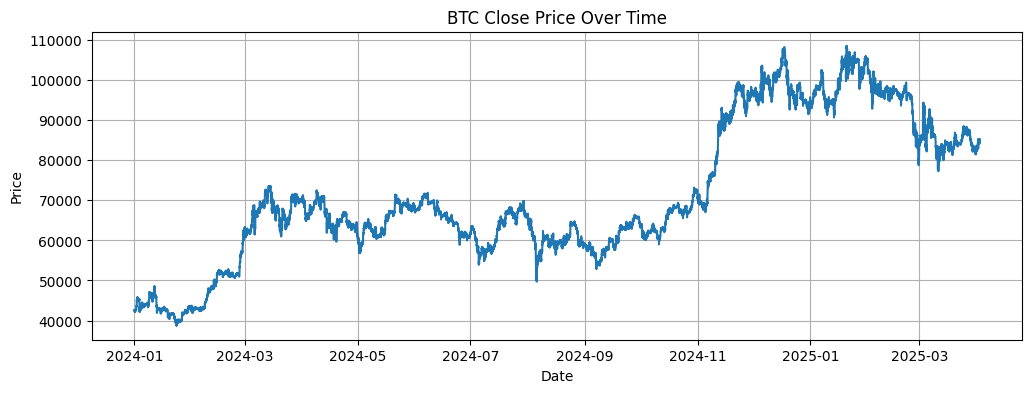

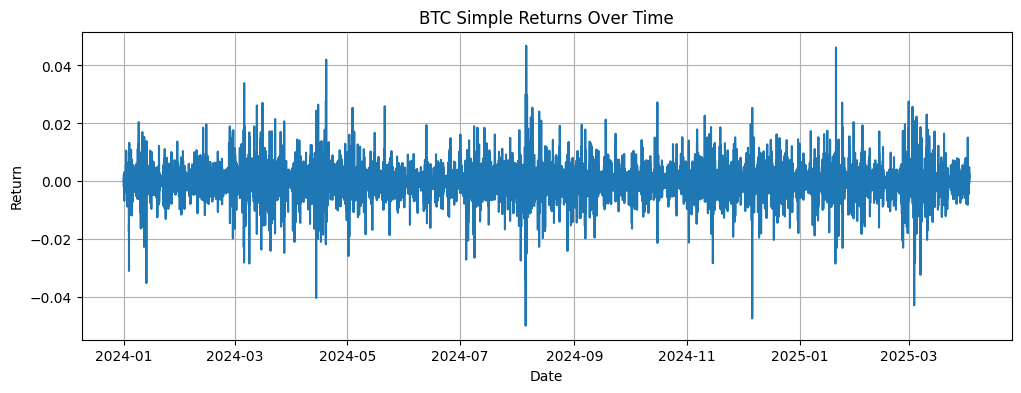

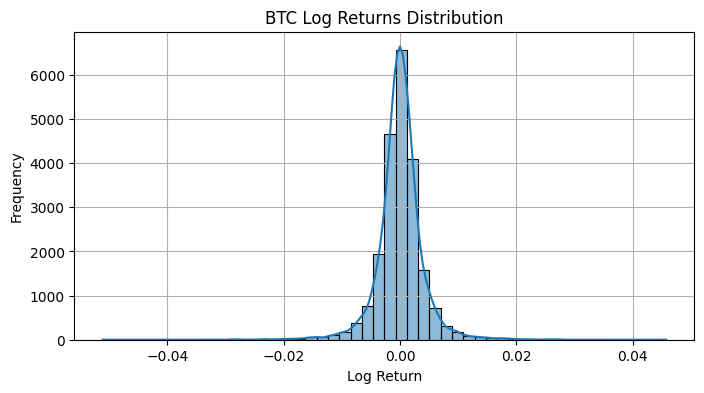

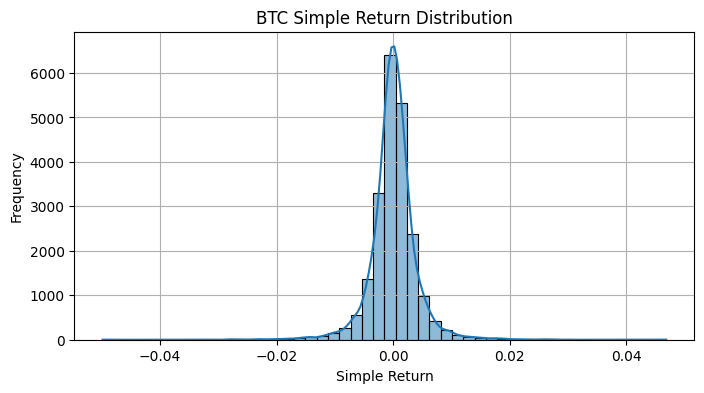

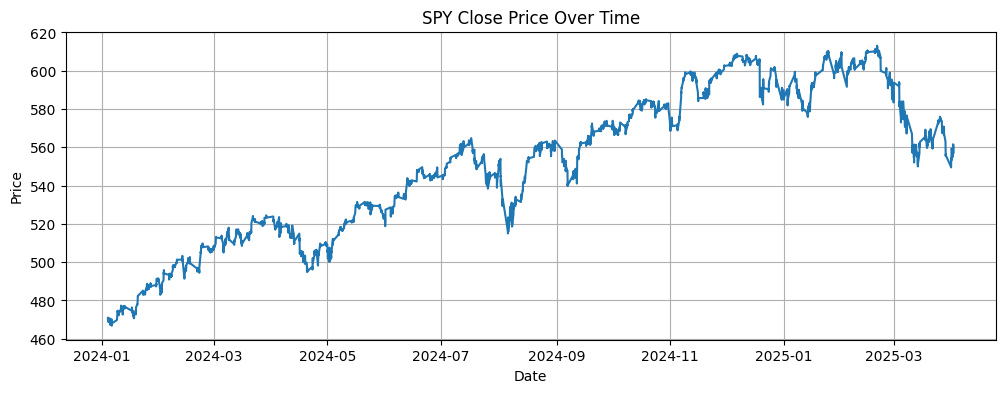

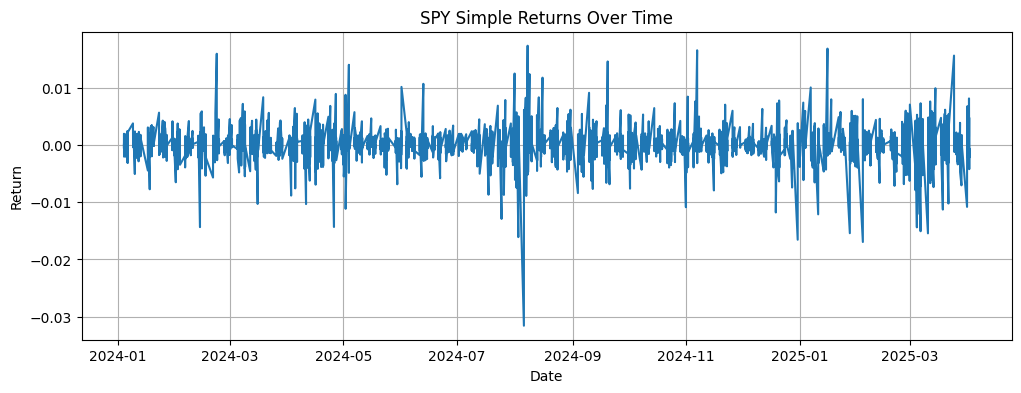

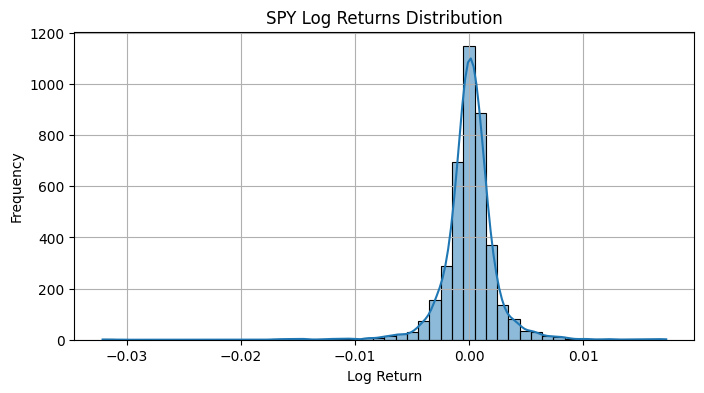

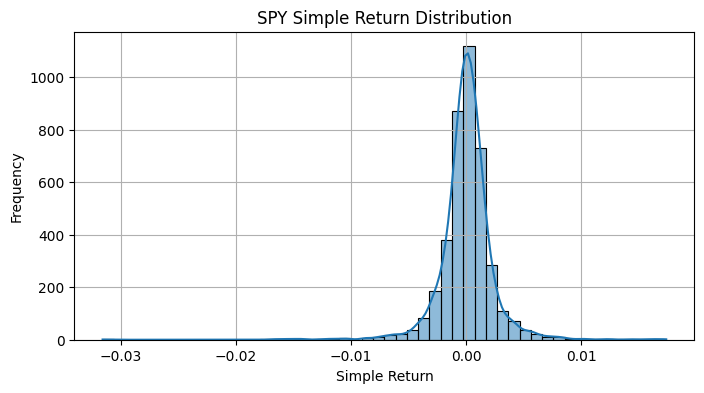

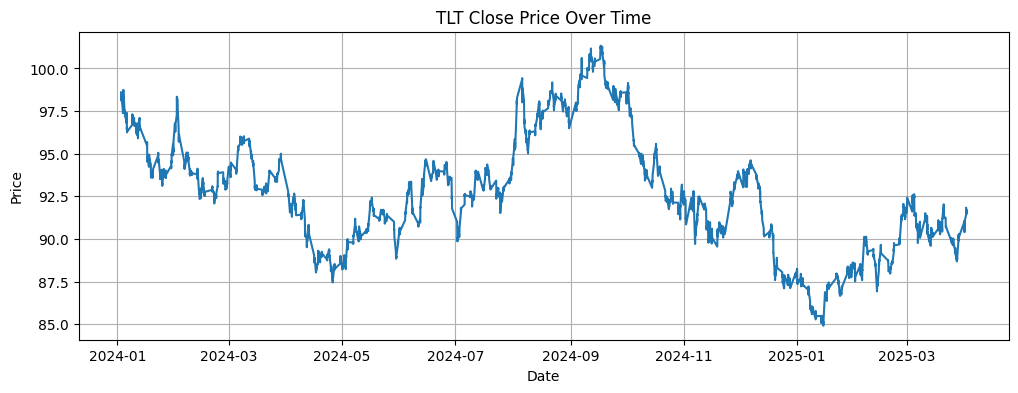

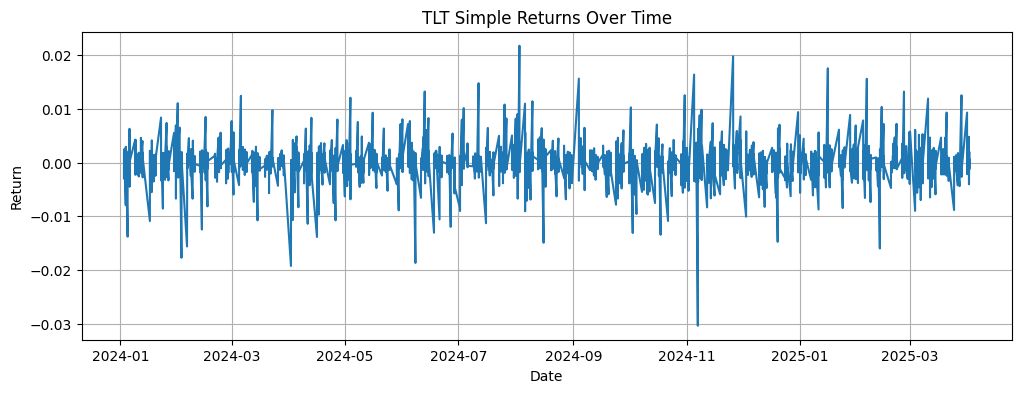

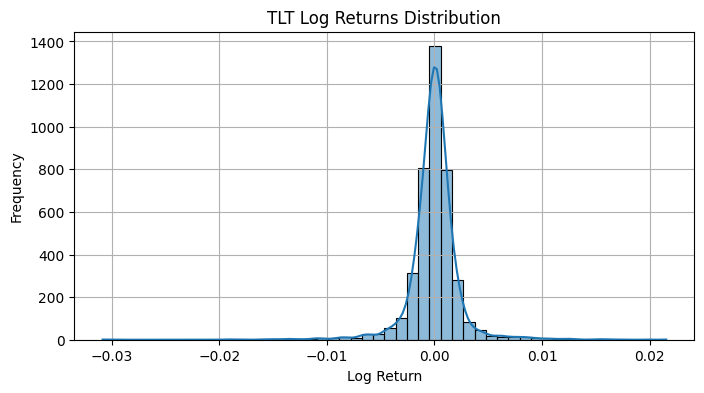

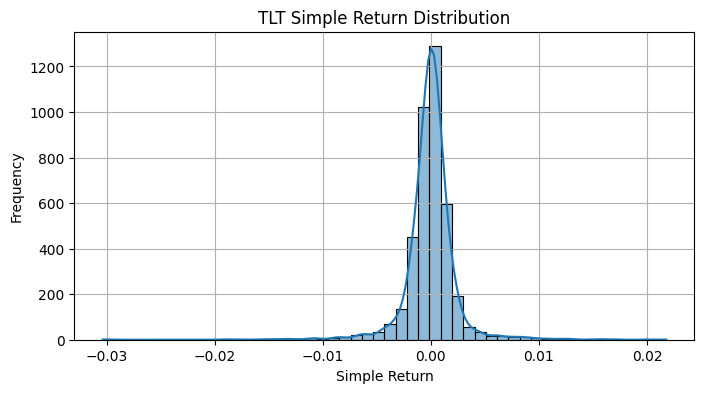

In [ ]:
# Compute simple and log returns
for asset, df in zip(['BTC', 'SPY', 'TLT'], [btc, spy, tlt]):

    # 1. Line plot of Close prices
    plt.figure(figsize=(12, 4))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.title(f'{asset} Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

    # 2. Line plot of simple returns
    plt.figure(figsize=(12, 4))
    plt.plot(df['Date'], df['simple_returns'], label='Simple Returns')
    plt.title(f'{asset} Simple Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

    # 3. Histogram of log returns
    plt.figure(figsize=(8, 4))
    sns.histplot(df['log_returns'].dropna(), kde=True, bins=50)
    plt.title(f'{asset} Log Returns Distribution')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 4. Histogram of simple returns
    plt.figure(figsize=(8, 4))
    sns.histplot(df['simple_returns'].dropna(), kde=True, bins=50)
    plt.title(f'{asset} Simple Return Distribution')
    plt.xlabel('Simple Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Correlation matrix between assets

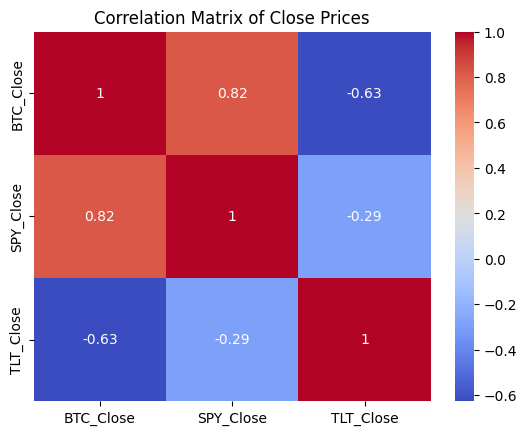

In [98]:
# close prices
combined = btc[['Date', 'Close']].rename(columns={'Close': 'BTC_Close'})
combined = combined.merge(spy[['Date', 'Close']].rename(columns={'Close': 'SPY_Close'}), on='Date')
combined = combined.merge(tlt[['Date', 'Close']].rename(columns={'Close': 'TLT_Close'}), on='Date')

sns.heatmap(combined[['BTC_Close', 'SPY_Close', 'TLT_Close']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Close Prices")
plt.show()


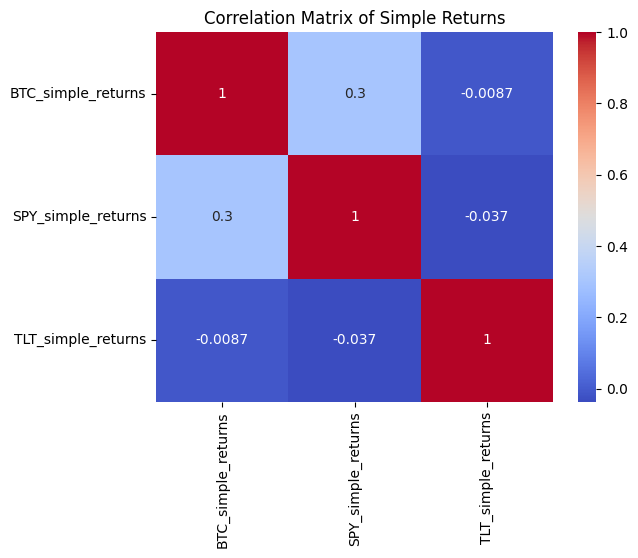

In [99]:
# for simple returns
combined = btc[['Date', 'simple_returns']].rename(columns={'simple_returns': 'BTC_simple_returns'})
combined = combined.merge(spy[['Date', 'simple_returns']].rename(columns={'simple_returns': 'SPY_simple_returns'}), on='Date')
combined = combined.merge(tlt[['Date', 'simple_returns']].rename(columns={'simple_returns': 'TLT_simple_returns'}), on='Date')

sns.heatmap(combined[['BTC_simple_returns', 'SPY_simple_returns', 'TLT_simple_returns']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Simple Returns")
plt.show()


### Correlations between technical indicators 

### BTC

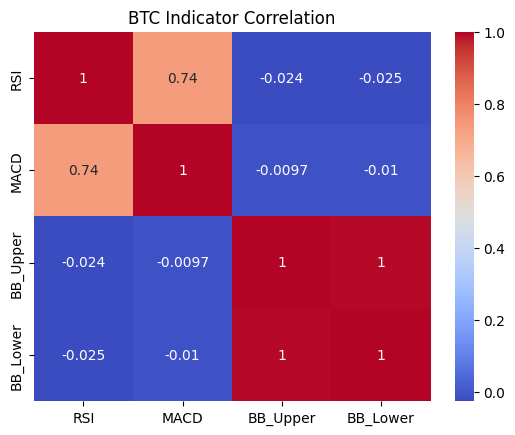

In [102]:
indicators_btc = btc[['RSI', 'MACD', 'BB_Upper', 'BB_Lower']]  # example
sns.heatmap(indicators_btc.corr(), annot=True, cmap='coolwarm')
plt.title("BTC Indicator Correlation")
plt.show()

In [103]:
X = add_constant(indicators_btc.dropna())
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

   Variable         VIF
0     const   34.896960
1       RSI    2.188897
2      MACD    2.187481
3  BB_Upper  122.215371
4  BB_Lower  122.224360


### SPY

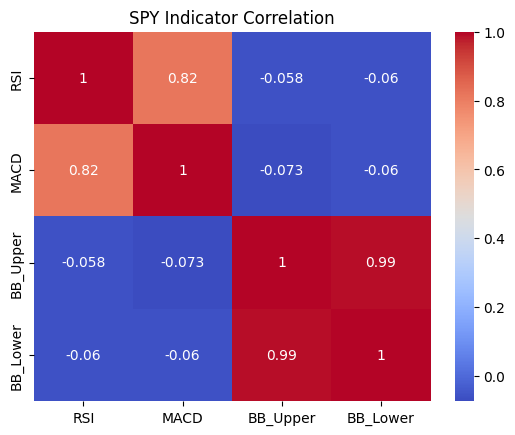

In [104]:
indicators_spy = spy[['RSI', 'MACD', 'BB_Upper', 'BB_Lower']]  
sns.heatmap(indicators_spy.corr(), annot=True, cmap='coolwarm')
plt.title("SPY Indicator Correlation")
plt.show()

In [105]:
X = add_constant(indicators_spy.dropna())
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

   Variable         VIF
0     const  231.451845
1       RSI    3.063192
2      MACD    3.087691
3  BB_Upper   43.332192
4  BB_Lower   43.270660


### TLT

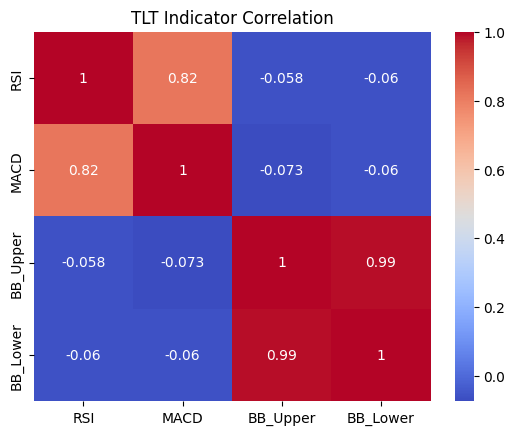

In [106]:
indicators_tlt = tlt[['RSI', 'MACD', 'BB_Upper', 'BB_Lower']]  # example
sns.heatmap(indicators_spy.corr(), annot=True, cmap='coolwarm')
plt.title("TLT Indicator Correlation")
plt.show()

In [107]:
X = add_constant(indicators_tlt.dropna())
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

   Variable         VIF
0     const  779.273561
1       RSI    3.375277
2      MACD    3.387848
3  BB_Upper   14.199594
4  BB_Lower   14.197107
